In [187]:
# pip install astropy

In [188]:
# pip install "numpy<2"

In [189]:
import matplotlib.pyplot as plt
import numpy as np
from astropy.io import fits
from astropy.wcs import WCS
import astropy
from astropy import units as u
from astropy.utils.data import download_file
from astropy.io import fits
from astropy.coordinates import SkyCoord
from astropy.wcs import WCS
from astropy.constants import c

#import healpy as hp

In [ ]:
import json
import os
import glob

with open(config_path, "r") as f:
    config = json.load(f)

cfg = config
folder = f"data/{cfg['programID']}"

In [ ]:
# Find the original spectral cube
cube_path = os.path.join(folder, cfg["fits_file"])  # typically the *reduced*.fits file
cube_file = sorted(glob.glob(cube_path))[0]  # use glob to handle wildcard

# Open header to get RESTFRQ
with fits.open(cube_file) as hdul:
    cube_header = hdul[0].header
    f_rest = cube_header["RESTFRQ"]

In [191]:
# folder = "data/M09BU04_C18O"

In [ ]:
rms_mult = cfg['noise_multiplier']

In [192]:
file = "/Users/macbook/Desktop/ngc7538/"+folder+"/mom0.fits"
psi_file = "/Users/macbook/Desktop/ngc7538/"+folder+"/psi"+str(rms_mult)+"x.fits"
psi = fits.getdata(psi_file, ext=0)

In [193]:
psi_file = fits.open(psi_file)
psi = psi_file[0].data

In [194]:
# header_custom_2 = hdu[0].header.copy()
# header_custom_2['NAXIS1'] = header_custom_2['NAXIS1'] // 2
# header_custom_2['NAXIS2'] = header_custom_2['NAXIS2'] // 2

# psi, footprint = reproject_interp(hdu, header_custom_2)
# psi_wcs_reproj = WCS(header_custom_2)

In [195]:
def pol_vec_components(p, psi):
    psi = psi * np.pi/2 + np.pi/2 
    vx = p*np.cos(psi)
    vy = p*np.sin(psi)
    return vx, vy

vx, vy = pol_vec_components(1, psi)
vx, vy = pol_vec_components(1, psi)
psi = psi + np.pi/2 + np.pi/2 
vx = np.cos(psi)
vy = np.sin(psi)

# hdu = fits.open(file)
# wcs = WCS(hdu[0].header)
# file_map = fits.getdata(file, ext=0)

In [196]:
a = fits.open(file)
mom0_map = a[0].data
mom0_map.shape

l1 = len(mom0_map[0,:])
l2 = len(mom0_map[:,0])
x = np.linspace(0, l1-1, l1)
y = np.linspace(0, l2-1, l2)

In [197]:
# header_custom_2 = a[0].header.copy()
# header_custom_2['NAXIS1'] = header_custom_2['NAXIS1'] // 2
# header_custom_2['NAXIS2'] = header_custom_2['NAXIS2'] // 2

# header_custom_2['CRPIX1'] = header_custom_2['CRPIX1'] // 2
# header_custom_2['CRPIX2'] = header_custom_2['CRPIX2'] // 2
# map_reproj, footprint = reproject_interp(a, header_custom_2)
# wcs_reproj = WCS(header_custom_2)

In [198]:
# l1 = len(map_reproj[0,:])
# l2 = len(map_reproj[:,0])
# x = np.linspace(0, l1-1, l1)
# y = np.linspace(0, l2-1, l2)

In [199]:
# pip install reproject &> /dev/null

In [200]:
from reproject import reproject_interp
from astropy.io.fits import Header

contour = fits.open("/Users/macbook/Desktop/ngc7538/iext_cal_beam_2d.fits")
contour_data = contour[0].data
contour_wcs = WCS(contour[0].header)

header_custom = contour[0].header.copy()

header_custom['NAXIS1'] = header_custom['NAXIS1'] // 2
header_custom['NAXIS2'] = header_custom['NAXIS2'] // 2

header_custom['CRPIX1'] = header_custom['CRPIX1'] // 2
header_custom['CRPIX2'] = header_custom['CRPIX2'] // 2

jcmt_reprojected, footprint = reproject_interp(contour, header_custom)
wcs_reprojected_jcmt = WCS(header_custom)


Set OBSGEO-B to    19.822839 from OBSGEO-[XYZ].
Set OBSGEO-H to     4120.022 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


In [ ]:
k = 4

# === Add annotation ===
velocity_range = cfg["velocity_range"]

noise_txt_path = os.path.join(folder, "noise"+str(rms_mult)+"x.txt")
noise = float(np.loadtxt(noise_txt_path))

total_noise = noise

Set OBSGEO-B to    19.822810 from OBSGEO-[XYZ].
Set OBSGEO-H to       -3.003 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


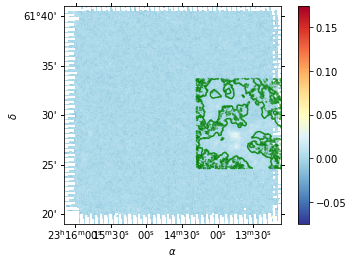

In [201]:
fig = plt.figure()
fig.suptitle(f"Program ID: {cfg['programID']}", fontsize=14)
ax = plt.subplot(projection=WCS(a[0].header))

im = ax.imshow(mom0_map, origin='lower', cmap='RdYlBu_r')
ax.set_facecolor("white")

ax.contour(jcmt_reprojected, levels=[5, 10, 15], colors='green', alpha=0.5, linewidths=1.2, transform=ax.get_transform(wcs_reprojected_jcmt))
ax.quiver(x[::k], y[::k], vx[::k,::k], vy[::k,::k], units='xy', pivot='mid', headlength=0, headaxislength=0, color='black', scale=0.3)

plt.xlabel(r'$\alpha$')
plt.ylabel(r'$\delta$')
fig.colorbar(im)

plt.text(0.05, 0.95,
         str(rms_mult)+f"rms: {total_noise:.5f}\n"
         f"Velocity: {velocity_range[0]:.1f}–{velocity_range[1]:.1f} km/s",
         transform=ax.transAxes,
         ha='left', va='top',
         fontsize=9,
         bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.7))

plt.savefig(folder + "/VGT_range_"+str(rms_mult)+"rms.png", transparent=True, dpi=1200)
plt.show()